# 11 -- Natural Language Processing (NLP)

* Structuring and cleaning text data
* EDA using term frequency
* Sentiment analysis
* Topic modeling

# Data

Some of the sources we'll be looking at...

* [Jane Austen novels](https://github.com/juliasilge/janeaustenr) -- github
* [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus) of 500 text samples in American English
  * The first million+ word corpus collected from various sources
* [20 Newsgroups dataset](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#loading-the-20-newsgroups-dataset) -- scikit-learn.org
  * a collection of ~20k newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups
  * the dataset has become a popular for text classification and text clustering.
* Tweets

# Jane Austen

Analysis of her books.

### Reading

* Chapter 3 of [Tidy Text Mining](https://www.tidytextmining.com/tfidf.html)

### References

* [Jane Austen's books](https://github.com/juliasilge/janeaustenr) in R (Julia Silge) -- github.com
* [austen_books.csv](https://github.com/ds5110/summer-2021/raw/master/data/austen_books.csv) for DS 5110 -- github

In [2]:
# Load the data from github
import pandas as pd
import numpy as np

url = "https://github.com/ds5110/summer-2021/raw/master/data/austen_books.csv"
df = pd.read_csv(url, index_col=False).drop('Unnamed: 0', axis=1)

df

,text,book
0,SENSE AND SENSIBILITY,Sense & Sensibility
1,NaN,Sense & Sensibility
2,by Jane Austen,Sense & Sensibility
3,NaN,Sense & Sensibility
4,(1811),Sense & Sensibility
...,...,...
73417,national importance.,Persuasion
73418,NaN,Persuasion
73419,NaN,Persuasion
73420,NaN,Persuasion


# Clean and inspect the data

* the data: Jane Austen's books as a single dataframe
* **document** (definition): the text from a single row in the dataframe
  * a tweet would be a document if we're analyzing tweets
  * likewise, an IMDb movie review would be a document
  * with this definition, a Jane Austen book is a collection of documents

In [3]:
# List the book names
books = df['book'].unique()
[print(book) for book in books];

Sense & Sensibility
Pride & Prejudice
Mansfield Park
Emma
Northanger Abbey
Persuasion


In [4]:
# Remove rows with missing data
n_rows = df.shape[0]
df = df.dropna()

n_clean = df.shape[0]
print('{:,} rows dropped = {:.2f}%'.format(n_rows - n_clean, 100 * (1 - n_clean / n_rows)))

11,143 rows dropped = 15.18%


In [5]:
# Extract and inspect the text for a book (as a pandas Series)
book = df[df['book'] == books[0]]['text']
first_line = book[0]
print(type(book))
print('book.shape:', book.shape)
print('first_line = book[0]:', first_line)
print('type(first_line)', type(first_line))
print('book[15]:', book[15])

<class 'pandas.core.series.Series'>
book.shape: (10596,)
first_line = book[0]: SENSE AND SENSIBILITY
type(first_line) <class 'str'>
book[15]: respectable a manner as to engage the general good opinion of their


# Bag of words -- tf -- sparsity

* The bag-of-words model represents text as numerical feature vectors as follows:
  * Step 1: create a vocabulary of unique tokens
  * Step 2: construct a feature vector for each document with counts of word occurence
* Unique words in each document typically represent only a small subset of all the words in the bag-of-words vocabulary
* Therefore, feature vectors will be sparse (i.e., mostly zeros)

## Classes for text analysis

* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) -- Converts collection of text documents to a sparse matrix of token counts
* [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) -- Transforms count matrix to a normalized tf **or** tf-idf representation
* [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) -- equivalent to CountVectorizer followed by TfidfTransformer



In [6]:
# Load the sklearn classes for text analysis
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# A toy demo

In [7]:
# Use CountVectorizer to create a bag of words (matrix of feature counts)
count = CountVectorizer()
docs = np.array(['The sun is shining',
                 'The weather is sweet',
                 'The sun is shining, the weather is sweet,'
                 'and one and one is two'])
bag = count.fit_transform(docs)

In [8]:
# The vocabulary
count.vocabulary_

{'and': 0,
 'is': 1,
 'one': 2,
 'shining': 3,
 'sun': 4,
 'sweet': 5,
 'the': 6,
 'two': 7,
 'weather': 8}

In [9]:
# The bag
bag

<3x9 sparse matrix of type '<class 'numpy.int64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [10]:
print(type(bag))

<class 'scipy.sparse.csr.csr_matrix'>


### Sparse matrices

CountVectorizer returns `csr_matrix` -- yet another matrix format!?

* [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)
  * Sparse matrices support addition, subtraction, multiplication, division, and matrix power
  * [discussion of sparsity](https://scikit-learn.org/stable/modules/feature_extraction.html#sparsity) -- scikit-learn.org
* Advantages of the scipy CSR (Compressed Sparse Row) format:
  * efficient arithmetic operations CSR + CSR, CSR * CSR, etc.
  * efficient row (document) slicing
  * fast matrix-vector products
* Disadvantages:
  * slow column slicing operations
    * consider [CSC (Compressed Sparse Column) matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) instead
  * changes to the sparsity structure are expensive
    * consider [LIL (List of Lists)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) or [DOK (Dictionary of Keys)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html) alternatives

In [11]:
# Note: vocabulary is alphabetical
[print(doc) for doc in docs]
print('\n', count.vocabulary_)
print('\n', bag.toarray())

The sun is shining
The weather is sweet
The sun is shining, the weather is sweet,and one and one is two

 {'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}

 [[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


## Analyzing Jane Austen's books

In [12]:
# Use CountVectorizer and TfidfTransformer to compute the raw term frequencies

# NOTE: a "book" in this case is a pandas Series with length ~10K (number of lines)
count = CountVectorizer()
sparse_matrix = count.fit_transform(book)

print(type(sparse_matrix))
print('sparse_matrix.shape:', sparse_matrix.shape)

# Then compute the raw term frequencies (with TfidfTransformer)
# These are term frequencies for each document (row in the matrix)
# There are ~10K lines, and ~6K terms (features)
tf = TfidfTransformer(use_idf=False).fit_transform(sparse_matrix)

# TfidfTransformer returns 
print(type(tf))
print(tf.shape)
tf.toarray()

<class 'scipy.sparse.csr.csr_matrix'>
sparse_matrix.shape: (10596, 6305)
<class 'scipy.sparse.csr.csr_matrix'>
(10596, 6305)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
first_line = book[0]
first_line

'SENSE AND SENSIBILITY'

In [14]:
# Convert the first line of the book (a string) to an array of words (features)
first_line.lower().split()

['sense', 'and', 'sensibility']

In [15]:
# Get indices for the words in the first line
# Note that you need both .lower() & .split())
#   Without ".lower()", first_line throws a KeyError because it's all caps
#   Without ".split()", you get a long string that doesn't distinguish words
first_line_indices = [count.vocabulary_[word] for word in first_line.lower().split()] # need .lower()
first_line_indices

[4985, 309, 4987]

In [16]:
# Verify that the indices above agree with the first row of the sparse_matrix
# Note: the indices are the same as above, but the order has been lost
a = sparse_matrix[0, :] > 0
a = a.toarray()[0]
feature_indices = [i for i, x in enumerate(a) if x]
feature_indices

[309, 4985, 4987]

In [17]:
# Invert the transform
# Note: the order is incorrect, and there are no caps or punctuation
feature_names = count.get_feature_names()
[feature_names[i] for i in feature_indices]

['and', 'sense', 'sensibility']

# raw term frequencies -- tf(t,d) -- for an entire book

Plot the raw term (t = term = word) frequencies (histogram) for a book (here we redefine d = document = book)

In [58]:
# Compute term frequencies for an entire book

# Redefining sparse_matrix here (same as above, just for clarity)
# A book contains multiple rows
# Sparse matrix dimension is documents-by-vocabulary size: (10596, 6305)
book = df[df['book'] == books[0]]['text']
count = CountVectorizer()
sparse_matrix = count.fit_transform(book)

# First, convert the sparse array to an ndarray, then term sums
# .toarray() -- returns dense ndarray
# .sum(axis=0) -- returns sum over rows for each column (term)
a = sparse_matrix.toarray().sum(axis=0)
print(sparse_matrix.shape)
print(a.shape)

# .argsort() -- returns indicies that would sort the array
sorted_indices = np.argsort(-a)
sorted_count = [a[i] for i in sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]
print('Number of features:', len(sorted_features))
print('First 10 counts:', sorted_count[:10])
print('First 10 features:', sorted_features[:10])
print('Last 10 counts:', sorted_count[-10:])
print('Last 10 features:', sorted_features[-10:])

(10596, 6305)
(6305,)
Number of features: 6305
First 10 counts: [4116, 4105, 3571, 3490, 2543, 1979, 1861, 1757, 1613, 1383]
First 10 features: ['ah cousin', 'agreeable was', 'advantage and', '_do_ think', 'acquaintance what', 'acted well', 'all attempt', 'add aught', 'again miss', 'agreeable want']
Last 10 counts: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Last 10 features: ['active cheerful', 'active contriving', 'active fancy', 'active looks', 'active magistrate', 'active part', 'active powers', 'active service', 'actions will', 'all for']


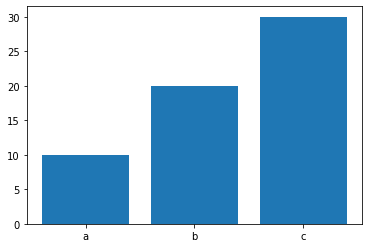

In [19]:
# Demo bar chart
import matplotlib.pyplot as plt

a = ['a', 'b', 'c']
b = [10,20,30]
plt.bar(a,b);  # width=1 

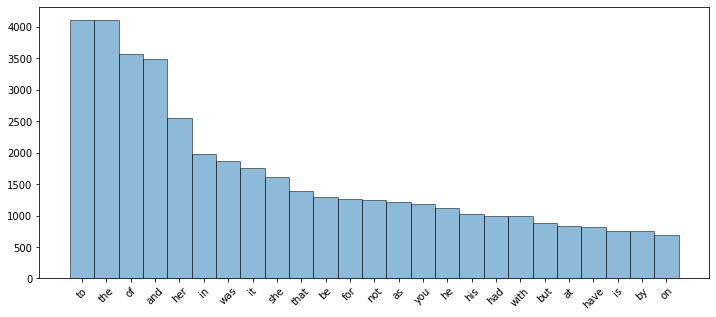

In [20]:
# Plot the raw term frequencies as a bar chart (most frequent)
plt.subplots(1,1,figsize=(12,5))
plt.bar(sorted_features[:25], sorted_count[:25], 
        width=1, alpha=.5, edgecolor='black')
plt.xticks(rotation=45);

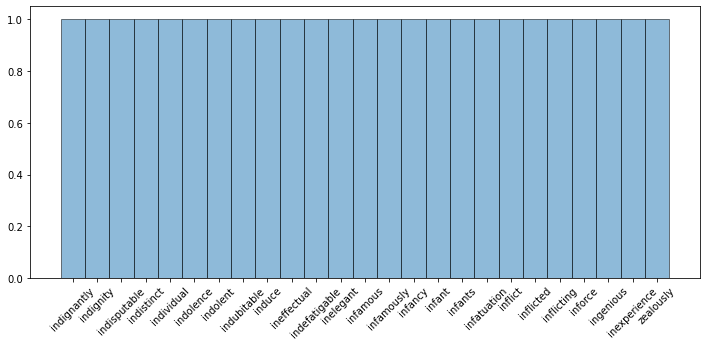

In [21]:
# Plot the raw term frequencies as a bar chart (least frequent)
plt.subplots(1,1,figsize=(12,5))
plt.bar(sorted_features[-25:], sorted_count[-25:], 
        width=1, alpha=.5, edgecolor='black')
plt.xticks(rotation=45);

# Zipf's law

Empirical relation between term frequency and inverse of rank in a list of word frequencies

$$
\mathrm{tf} = \frac{\gamma}{\mathrm{rank}}
$$
or
$$
\log(\mathrm{tf}) = \log(\gamma) - \log(\mathrm{rank})
$$



Recall

$$
a = \frac{\gamma}{b} = \gamma b^{-1}
$$

$$
\log a = \log \left(\gamma b^{-1}\right) 
= \log \gamma + \log b^{-1} = \log \gamma - \log b
$$

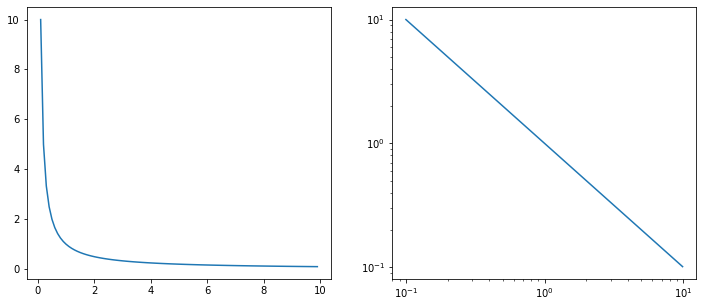

In [22]:
import numpy as np
import matplotlib.pyplot as plt

a = np.arange(.1, 10, .1)
gamma = -1.0
b = a**gamma

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(a,b)
ax[1].loglog(a,b)
plt.show();

6305


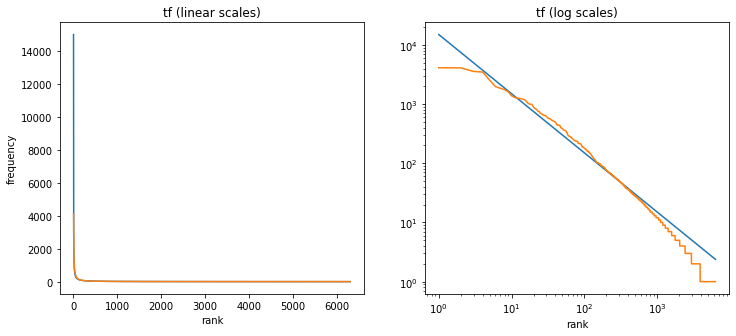

In [23]:
n = len(sorted_count)
print(n)
rank = np.arange(1, n + 1)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(rank, 1.5e+4 / rank)
ax[0].plot(rank, sorted_count)
ax[0].set_xlabel('rank')
ax[0].set_ylabel('frequency')
ax[0].set_title('tf (linear scales)')

ax[1].loglog(rank, 1.5e+4 / rank)
ax[1].loglog(rank, sorted_count)
ax[1].set_xlabel('rank')
ax[1].set_title('tf (log scales)')
plt.show();

# tf-idf

tf-idf attempts to find the words that are common and important, but not so common as to be unimportant.

$$
\mathrm{tf\mathrm{-}idf}(t, d) = \mathrm{tf}(t,d) * \mathrm{idf}(t)
$$
Typically, if $n$ is the number of documents and df(t) is the number of documents containing the term $t$, then
$$
\mathrm{idf}(t) = \log\left( \frac{n}{\mathrm{df}(t)} \right)
$$
* If a term $t$ shows up in all documents, df(t) = n, idf(t) = 0
* If a term shows up in no documents, idf = infinity (i.e., divide-by-0)
* In practice, idf(t) is maximum when $t$ shows up in 1 document (the minimum)
* See [TfidfTransformer reference docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for variations that avoid divide-by-zero


tfidf.shape: (10596, 6305)


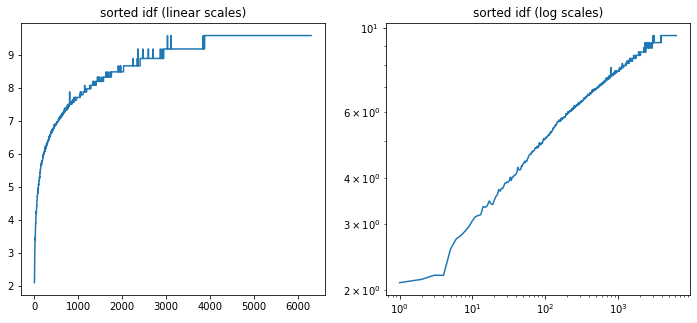

In [24]:
# EXERCISE: Plot idf -- it is linear in log-log plot, but smaller range than tf
from sklearn.pipeline import Pipeline

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(sparse_matrix)
print('tfidf.shape:', tfidf.toarray().shape)

sorted_idf = [transformer.idf_[i] for i in sorted_indices]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(rank, sorted_idf)
ax[0].set_title('sorted idf (linear scales)')
ax[1].loglog(rank, sorted_idf)
ax[1].set_title('sorted idf (log scales)')
plt.show();

# Corpus: Jane Austen novels

For this analysis, document = book, corpus = collection of books.

We'll see an example where a document is an IMDb review.  With twitter analyses, it's common that document = tweet.

6305
<class 'list'>
(6305,)


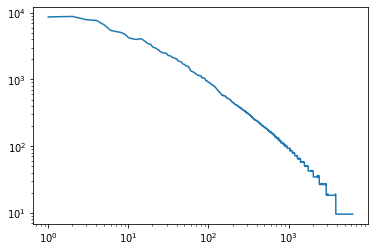

In [25]:
print(len(sorted_count))
print(type(sorted_count))
a = np.asarray(sorted_count)
print(a.shape)
b = np.asarray(sorted_idf)
max(a*b)

plt.loglog(rank, a*b)

In [26]:
# Convert the original dataframe into a list of books (corpus)
# Each book is a string (document in the corpus)
corpus = []
for title in books:
  book = df[df['book'] == title]['text']
  book = " ".join(book)
  corpus.append(book)
print(len(corpus)) # number of books (6)
print(corpus[0]) # first book

6
SENSE AND SENSIBILITY by Jane Austen (1811) CHAPTER 1 The family of Dashwood had long been settled in Sussex.  Their estate was large, and their residence was at Norland Park, in the centre of their property, where, for many generations, they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance.  The late owner of this estate was a single man, who lived to a very advanced age, and who for many years of his life, had a constant companion and housekeeper in his sister.  But her death, which happened ten years before his own, produced a great alteration in his home; for to supply her loss, he invited and received into his house the family of his nephew Mr. Henry Dashwood, the legal inheritor of the Norland estate, and the person to whom he intended to bequeath it.  In the society of his nephew and niece, and their children, the old Gentleman's days were comfortably spent.  His attachment to them all increased.  The constant attenti

# stop words

* Stop words like “and”, “the”, “him” are presumed to be unimportant.
* They may be removed.
* However, they may be useful for prediction, such as in classifying writing style or personality
* There are various ways to deal with stop words
* [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) has built-in `stop_words` with acknowledged "issues" -- scikit-learn.org
* [stop-words](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words) discussion -- scikit-learn.org

# tf-idf

* default keeps all words, even those that appear in all documents
* Setting `max_df = 5/6` will ignore words appear in all documents (i.e., df = 6/6)
* Set `stop_words="english"` will used canned stop words (overrides `max_df`)
* Recall: [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is equivalent to CountVectorizer followed by TfidfTransformer

### EXERCISE: In the next cell, try each vectorizer line in succession

tfidf: [0.         0.00056604 0.00056604 0.00056604 0.00056604 0.
 0.00056604 0.         0.00056604 0.00056604]
sorted tfidf: [0.6535662685387584, 0.5400270189677917, 0.2404360579149885, 0.22421616511913614, 0.20608804964141872, 0.1488672786581899, 0.14552360038688456, 0.13739203309427914, 0.12403447432122423, 0.09731935677511439]
sorted features: ['elinor', 'marianne', 'dashwood', 'jennings', 'willoughby', 'edward', 'lucy', 'brandon', 'ferrars', 'middleton']


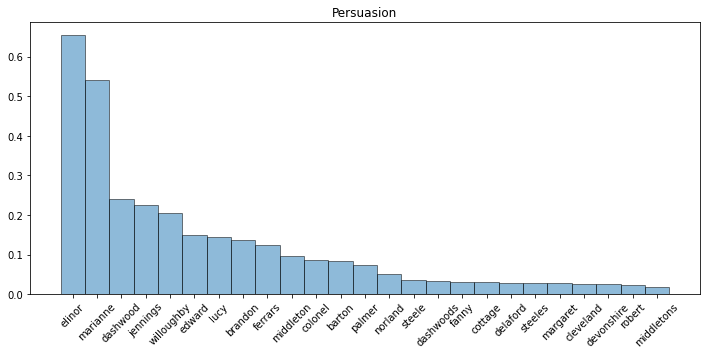

In [68]:
# Plot tfidf vs rank...compare each of the 3 ways for dealing with stop-words

vectorizer = TfidfVectorizer(stop_words="english") # this will cause altorithm to ignore max_df
#vectorizer = TfidfVectorizer() # no stop words and the "1" added to df (above) allows terms that appear in all documents
vectorizer = TfidfVectorizer(max_df = 5/6) # ignore words that appear in all documents

# sparse_matrix & feature_names defined here, and used below
sparse_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()

# Get highest tf-idf words in the first book
tfidf = sparse_matrix[0,:].toarray()[0]
print('tfidf:', tfidf[:10])

# Sort tfidf from large to small (default sort is increasing)
sorted_indices = np.argsort(-tfidf) # these are the indices of the sort
sorted_tfidf = [tfidf[i] for i in sorted_indices] # this is the sorted array
sorted_features = [feature_names[i] for i in sorted_indices] # features sorted by tfidf

print('sorted tfidf:', sorted_tfidf[:10])
print('sorted features:', sorted_features[:10])

plt.subplots(1,1,figsize=(12,5))
plt.bar(sorted_features[:25], sorted_tfidf[:25], 
        width=1, alpha=.5, edgecolor='black')
plt.title(title)
plt.xticks(rotation=45);

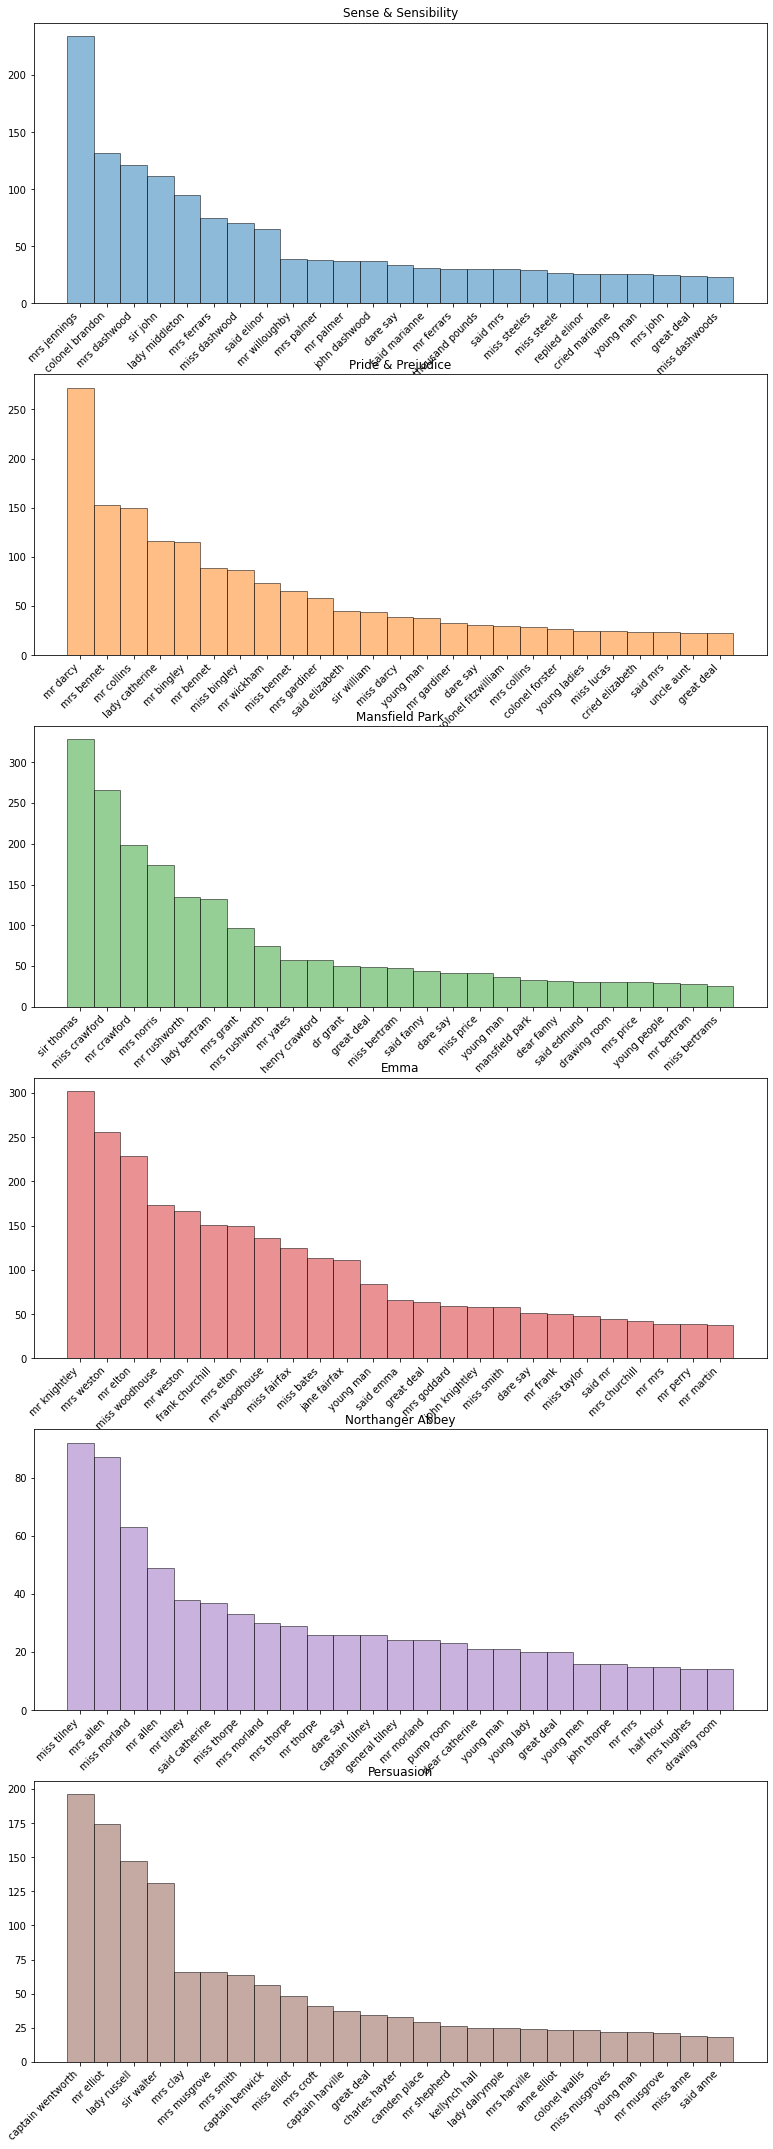

In [81]:
# Repeat analysis above, except for all the books

# Define a convenience function for plotting sorted features
def plot_book(sorted_features, sorted_tfidf, ax, title, color):
    ax.bar(sorted_features[:25], sorted_tfidf[:25], 
            width=1, alpha=.5, color=color, edgecolor='black')
    ax.set_title(title)
    ax.set_xticklabels(sorted_features[:25], rotation=45, ha='right');

# Analyze and plot one book at a time
n = len(books)
fig, ax = plt.subplots(n, 1, figsize=(12,5 * n))
plt.tight_layout(pad=5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0, len(books)):
   tfidf = sparse_matrix[i,:].toarray()[0]

   sorted_indices = np.argsort(-tfidf)
   sorted_tfidf = [tfidf[i] for i in sorted_indices]
   sorted_features = [feature_names[i] for i in sorted_indices]

   plot_book(sorted_features, sorted_tfidf, ax[i], books[i], colors[i])


# N-grams

EXERCISE: Try ngram_range = (1,2) and (2,2)

In [90]:
# Plot tfidf vs rank...compare each of the 3 ways for dealing with stop-words
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(2, 2)) # this will cause altorithm to ignore max_df
#vectorizer = TfidfVectorizer(ngram_range=(2, 2)) # no stop words and the "1" added to df (above) allows terms that appear in all documents
#vectorizer = TfidfVectorizer(max_df = 5/6, ngram_range=(2, 2)) # ignore words that appear in all documents

# sparse_matrix & feature_names defined here, and used below
sparse_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
print('len(feature_names):', len(feature_names))
print('some feature_names:', feature_names[0:10]) # some (not all) are 2-grams

len(feature_names): 230827
some feature_names: ['000', '000 did', '000 satisfy', '000 thereabouts', '10', '10 000', '10 allens', '10 day', '10 marianne', '10 opportunities']


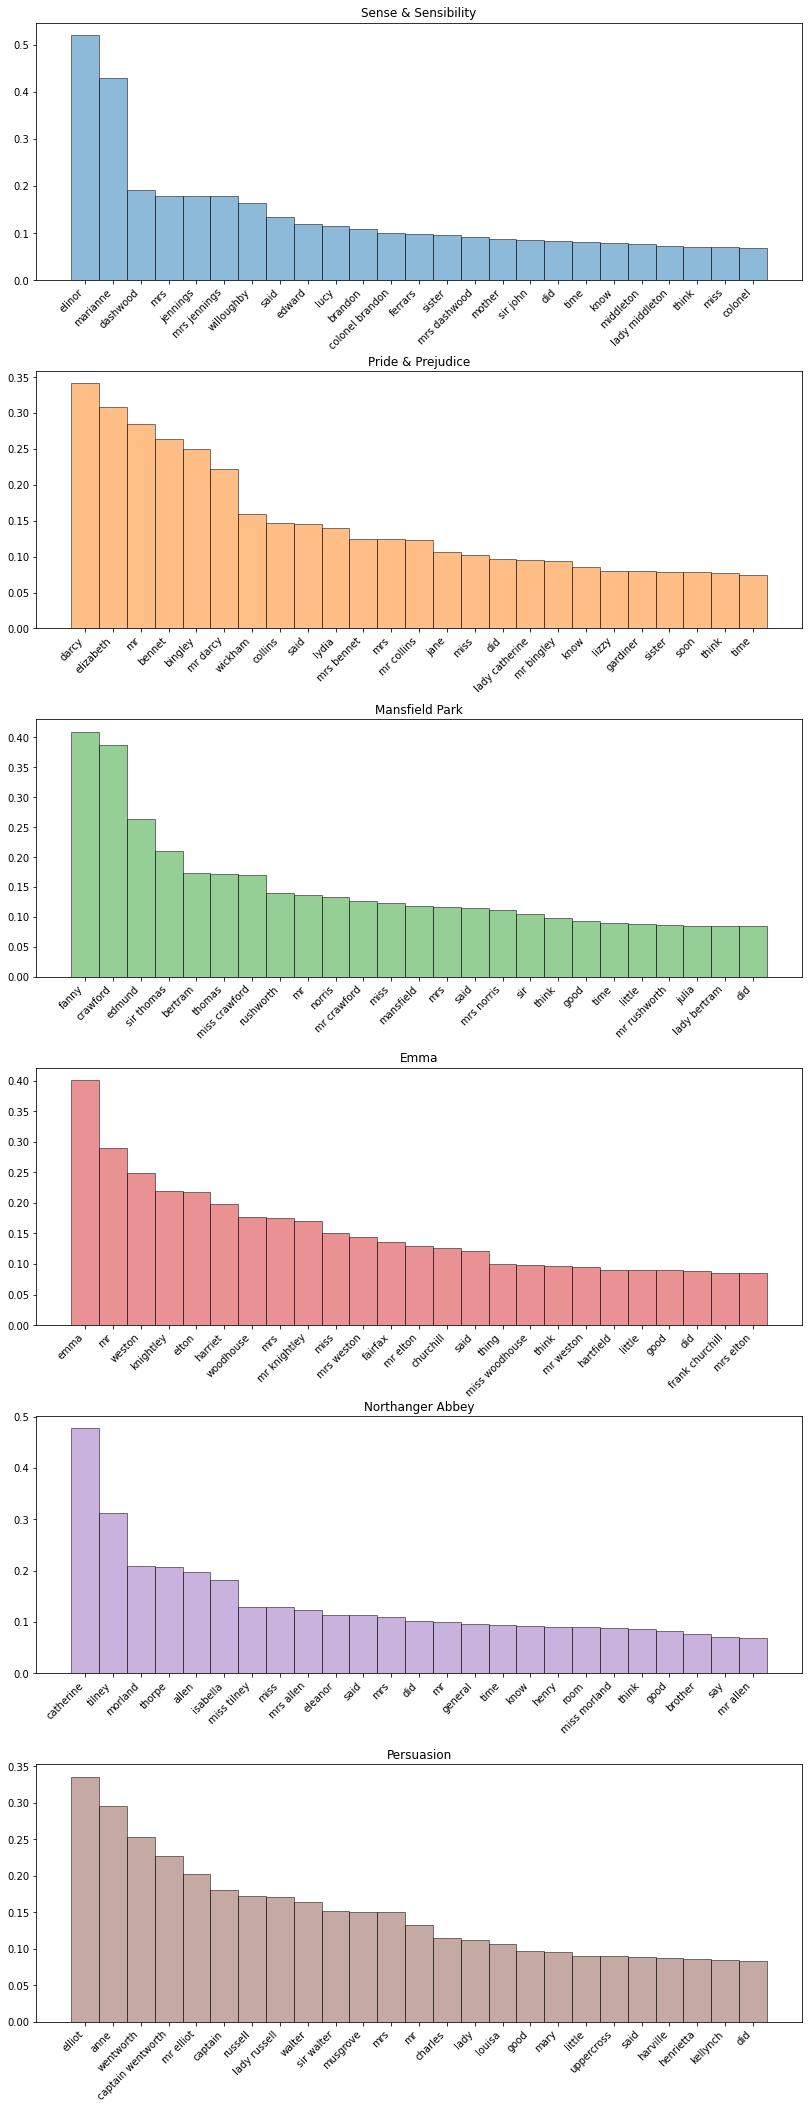

In [92]:
n = len(books)
fig, ax = plt.subplots(n, 1, figsize=(13, 5 * n))
plt.tight_layout(pad=7)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0, len(books)):
   tfidf = sparse_matrix[i,:].toarray()[0]

   sorted_indices = np.argsort(-tfidf)
   sorted_tfidf = [tfidf[i] for i in sorted_indices]
   sorted_features = [feature_names[i] for i in sorted_indices]

   plot_book(sorted_features, sorted_tfidf, ax[i], books[i], colors[i])